# Plotting a stock's price chart with corporate action overlay

Sometimes, a picture is worth a thousand words.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()

In [2]:
symbol <- "ASHOKLEY"
startDt <- as.Date(Sys.Date() - 10*365) #N-year chart
endDt <- Sys.Date()

# examples: https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

#make sure that the data exists

equitiesIndiaNse$EodTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol 
           & (SERIES == 'EQ' | SERIES == 'BE')) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()

equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt 
           & SYMBOL == symbol) %>%
    summarize(MAX_DT = max(TIME_STAMP), MIN_DT = min(TIME_STAMP)) %>%
    print()


# Source:   lazy query [?? x 2]
# Database: NORWAY:StockViz:R
  MAX_DT     MIN_DT    
  <chr>      <chr>     
1 2019-09-16 2009-09-22
# Source:   lazy query [?? x 2]
# Database: SWEDEN:StockVizDyn:R
  MAX_DT     MIN_DT    
  <chr>      <chr>     
1 2019-09-16 2009-09-22


In [3]:
# so the data exists in both so we can use the EodAdjustedTimeSeries

eodPxDf <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
    filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == symbol) %>%
    select(TIME_STAMP, CLOSE) %>%
    arrange(TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP=as.Date(TIME_STAMP)) %>%
    as.data.frame()

minPx <- min(eodPxDf$CLOSE, na.rm=T)
maxPx <- max(eodPxDf$CLOSE, na.rm=T)

print("HEAD:")
print(head(eodPxDf))
print("TAIL:")
print(tail(eodPxDf))
print("SUMMARY:")
print(summary(eodPxDf$CLOSE))

[1] "HEAD:"
  TIME_STAMP  CLOSE
1 2009-09-22 15.575
2 2009-09-23 16.025
3 2009-09-24 16.000
4 2009-09-25 15.750
5 2009-09-29 15.850
6 2009-09-30 15.875
[1] "TAIL:"
     TIME_STAMP CLOSE
2452 2019-09-06 63.90
2453 2019-09-09 62.90
2454 2019-09-11 63.70
2455 2019-09-12 62.50
2456 2019-09-13 63.45
2457 2019-09-16 62.45
[1] "SUMMARY:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.82   21.12   35.45   55.25   84.80  156.15 


In [4]:
corpActDf <- equitiesIndiaNse$CorporateActions() %>%
    filter(EX_DATE >= startDt & EX_DATE <= endDt & SYMBOL == symbol & SERIES == 'EQ') %>%
    select(T = EX_DATE, PURPOSE) %>%
    collect() %>%
    group_by(T) %>%
    mutate(PURPOSE = paste0(PURPOSE, collapse='/')) %>%
    as.data.frame()

corpActDf$T <- as.Date(corpActDf$T)

corpEvtDf <- equitiesIndiaNse$CorporateEvents() %>%
    filter(EVENT_DATE >= startDt & EVENT_DATE <= endDt & SYMBOL == symbol) %>%
    select(T = EVENT_DATE, PURPOSE) %>%
    collect() %>%
    group_by(T) %>%
    mutate(PURPOSE = paste0(PURPOSE, collapse='/')) %>%
    as.data.frame()

corpEvtDf$T <- as.Date(corpEvtDf$T)

print(corpActDf)
print(corpEvtDf)

            T                                                        PURPOSE
1  2011-06-29           ANNUAL GENERAL MEETING AND DIVIDEND RS.2/- PER SHARE
2  2011-08-02                                                      BONUS 1:1
3  2012-07-12           ANNUAL GENERAL MEETING AND DIVIDEND RE.1/- PER SHARE
4  2010-07-16          ANNUAL GENERAL MEETING AND DIVIDEND RS.1.50 PER SHARE
5  2013-07-04 ANNUAL GENERAL MEETING / DIVIDEND - RE.0.60/- PER EQUITY SHARE
6  2014-07-18                                         ANNUAL GENERAL MEETING
7  2015-06-17            ANNUAL GENERAL MEETING/DIVIDEND - RE 0.45 PER SHARE
8  2016-07-13              ANNUAL GENERAL MEETING/DIVIDEND RE 0.95 PER SHARE
9  2017-07-11          ANNUAL GENERAL MEETING/DIVIDEND - RS 1.56/- PER SHARE
10 2018-07-09                                    DIVIDEND- RS 2.43 PER SHARE
11 2019-07-23           ANNUAL GENERAL MEETING/ DIVIDEND - RS 3.10 PER SHARE
            T                                           PURPOSE
1  2017-05-2

In [5]:
startDate <- first(eodPxDf$TIME_STAMP)
endDate <- last(eodPxDf$TIME_STAMP)

xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)

### Price chart (log of close)

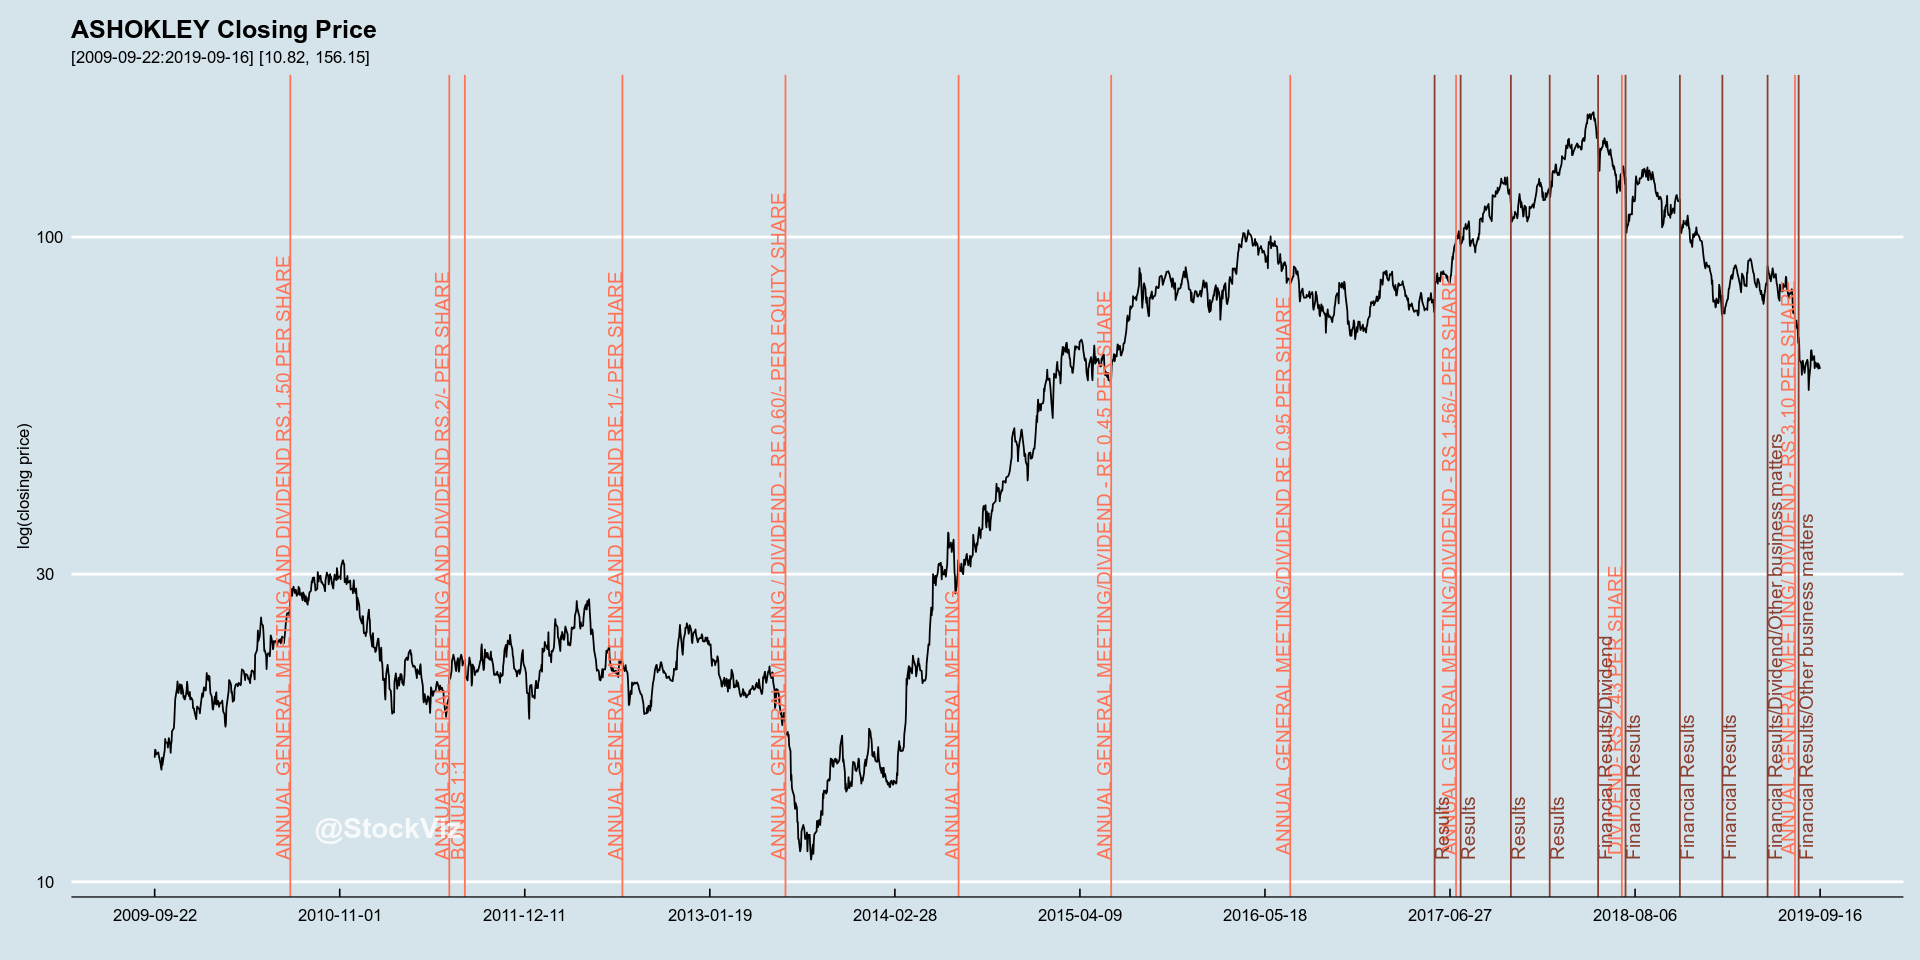

In [6]:
ggplot(eodPxDf, aes(x = TIME_STAMP, y = CLOSE)) + 
    theme_economist() +
    geom_line() + 
    geom_vline(xintercept = corpActDf$T, colour="coral1") +
    annotate("text", x = corpActDf$T, y = min(eodPxDf$CLOSE, na.rm=T), label = corpActDf$PURPOSE,
            col='coral1', cex = 4, angle = 90, hjust = 0, vjust=0) +
    geom_vline(xintercept = corpEvtDf$T, colour="coral4") +
    annotate("text", x = corpEvtDf$T, y = min(eodPxDf$CLOSE, na.rm=T), label = corpEvtDf$PURPOSE,
            col='coral4', cex = 4, angle = 90, hjust = 0, vjust=1) +
    scale_y_log10() +
    scale_x_date(breaks = xAxisTicks) +
    labs(x='', y='log(closing price)', fill='', color='',
         title=sprintf("%s Closing Price", symbol), 
         subtitle=sprintf("[%s:%s] [%.2f, %.2f]", startDate, endDate, minPx, maxPx)) +
    annotate("text", x=startDate, y=min(eodPxDf$CLOSE, na.rm=T), label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

### Cumulative returns and drawdowns

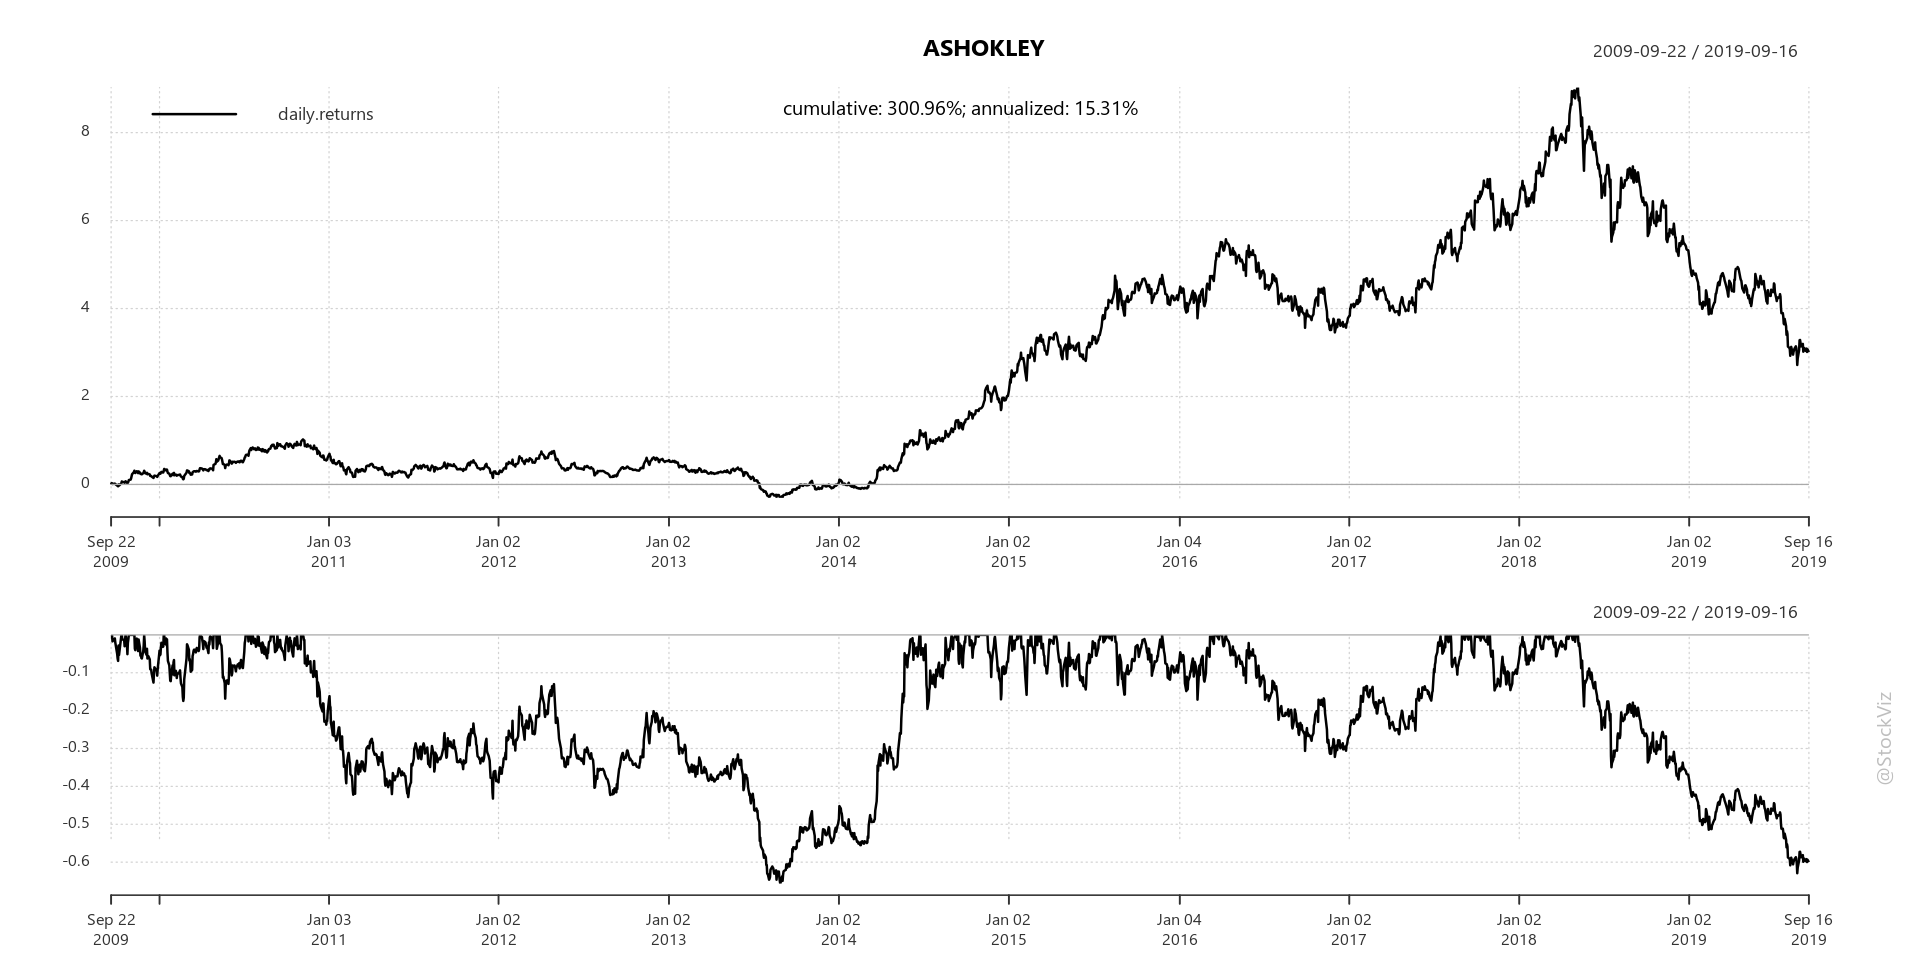

In [7]:
dailies <- dailyReturn(xts(eodPxDf$CLOSE, eodPxDf$TIME_STAMP))
Common.PlotCumReturns(dailies, symbol, NA)

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)